# To create a Gap strategy on Nifty 50

In [1]:
%%html
<style>
.container{width: 100%}
</style>

## Imports

In [2]:
import pandas_ta as ta
import numpy as np
from datetime import datetime, date, timedelta
import missingno

## Parameters for the strategy

In [3]:
buy = 5
sell = 5
trigger_buy = 0.02
trigger_sell = 0.03
sell_sl = 0.02
buy_sl = 0.02

## Instanciate a instance of pynse

In [4]:
from pynse import *
nse = Nse()


## Download the list of symbols from nsePy

In [5]:
# Import a list of all symbols you need
symbols = nse.symbols["Nifty50"]

## Determine the dates from which you want the data 

In [6]:
from_ = date(2014,1,1)
to_ = date(2022,1,1)

## Download the data from Nse website using pynse library

In [7]:
def get_data(symbols):
    final_df = pd.DataFrame()
    for i in symbols:
        df = pd.DataFrame()
        df = nse.get_hist(i, from_date=from_, to_date=to_)
        df["security"] = i
        df["pct_chg"] = df["close"].pct_change()
        df["range"] = df['high'] - df["low"]
        df["overnight_gap"] = (df["open"]-df["close"].shift(1))/df["close"].shift(1)
        final_df = pd.concat([final_df, df])
    return final_df

### Download the data and benchmark i.e. Nifty 50

In [8]:
%%time
master = get_data(symbols)

Wall time: 9min 20s


In [9]:
master

,open,high,low,close,volume,security,pct_chg,range,overnight_gap
Date,,,,,,,,,
2014-01-01,154.55,157.75,154.55,156.30,851727,ADANIPORTS,NaN,3.20,NaN
2014-01-02,155.70,159.40,151.10,152.65,2862278,ADANIPORTS,-0.023353,8.30,-0.003839
2014-01-03,151.50,153.85,147.50,149.90,1636752,ADANIPORTS,-0.018015,6.35,-0.007534
2014-01-06,150.50,152.50,149.00,150.85,750034,ADANIPORTS,0.006338,3.50,0.004003
2014-01-07,150.85,152.20,145.30,145.95,1069056,ADANIPORTS,-0.032483,6.90,0.000000
...,...,...,...,...,...,...,...,...,...
2021-12-27,699.85,701.00,691.15,699.60,5094328,WIPRO,0.001647,9.85,0.002004
2021-12-28,703.00,707.50,701.55,705.45,5079022,WIPRO,0.008362,5.95,0.004860
2021-12-29,705.25,710.00,700.05,703.70,3949208,WIPRO,-0.002481,9.95,-0.000284


In [10]:
# Copy master into another variable and don't touch master
df = master.copy()

## Save the master file in the local drive

In [11]:
master.to_csv("Nifty 100 Data.csv")

In [12]:
# Inspect the shape of the data
df.shape

(97017, 9)

### Check for missing data 

<AxesSubplot:>

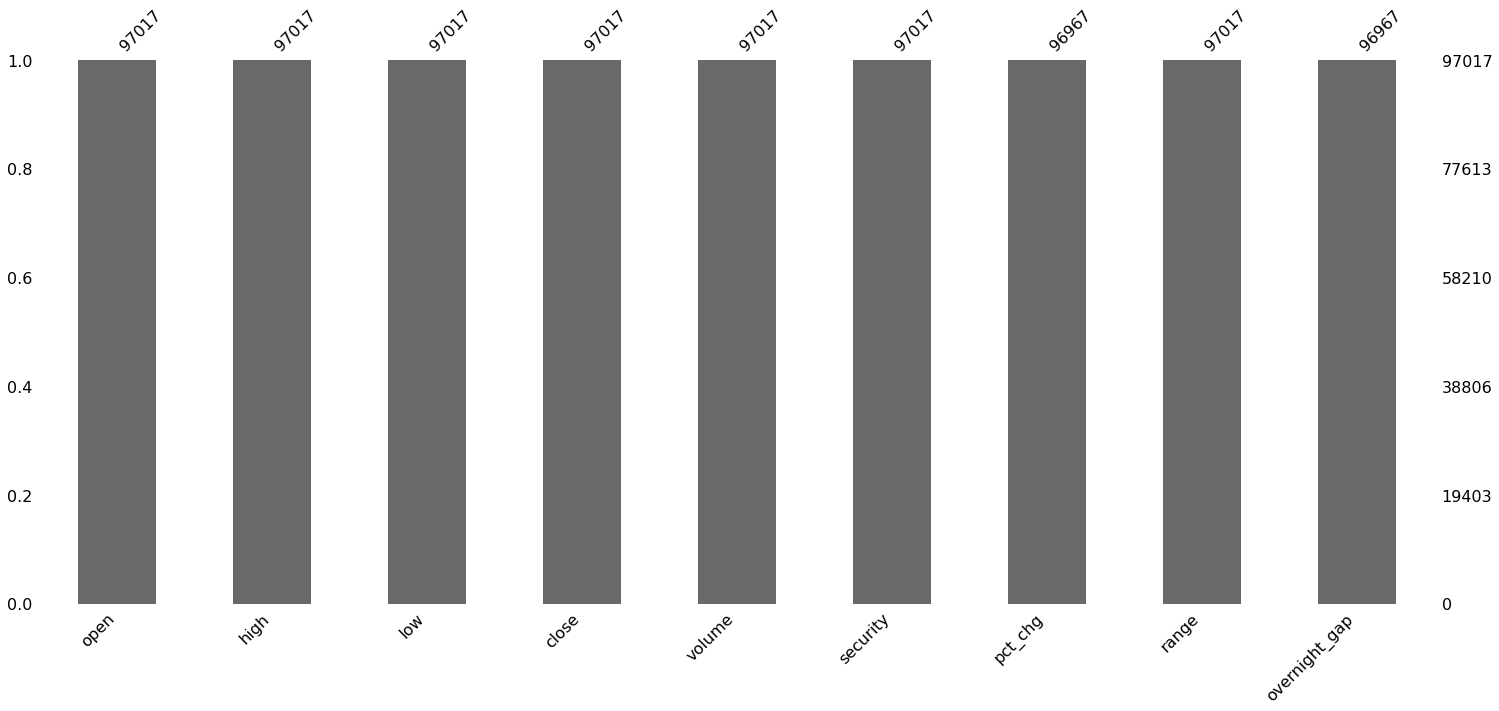

In [13]:
missingno.bar(df)

## We have no missing data except when taking percentage change, so we will drop the rows that contain missing data

In [14]:
df.dropna(inplace=True)

In [15]:
df.shape

(96967, 9)

## Sort the data by Datetime and overnight gap

In [16]:
df.sort_values(["Date","overnight_gap"], ascending=[True, False], inplace=True)

### Create a list of all dates for which the data is pulled

In [17]:
unique_index = df.index.unique()

## Create a gap rank based on overnight returns or gap

In [18]:
def gap_rank(df):
    df["gap_rank"] = 1
    gap_rank = 1
    for i in range(1,len(df.index)):
        if df.index[i] == df.index[i-1]:
            gap_rank = gap_rank + 1
            df.iloc[i,-1] = gap_rank
        else:
            gap_rank = 1
    return df

In [19]:
%%time
df = gap_rank(df)

Wall time: 11.8 s


### All current 50 stocks are not in the index in 2015. So find the number of data points for each day for a unique index

In [20]:
def stocks_in_a_day(df):
    number = []
    for j in unique_index:
        count = 0
        for i in range(len(df.index)):
            if df.index[i] == j:
                count = count + 1
        number.append(count)
    return number

In [21]:
%%time
stocks_for_day = stocks_in_a_day(df)

Wall time: 34min 1s


## Define the position you'll take based on the parameters

In [22]:
df.iloc[90:110,:]

,open,high,low,close,volume,security,pct_chg,range,overnight_gap,gap_rank
Date,,,,,,,,,,
2014-01-03,1727.00,1736.00,1711.00,1719.65,1375959,SBIN,-0.013170,25.00,-0.008952,43
2014-01-03,194.90,201.00,194.40,200.10,1137763,UPL,0.015994,6.60,-0.010409,44
2014-01-03,547.00,558.40,546.30,556.60,1107663,WIPRO,0.006601,12.10,-0.010760,45
2014-01-03,1258.00,1269.50,1245.60,1260.90,2403748,AXISBANK,-0.008960,23.90,-0.011239,46
2014-01-03,368.00,368.00,360.00,362.70,4950946,TATAMOTORS,-0.025916,8.00,-0.011683,47
2014-01-03,1020.00,1032.95,1008.05,1012.05,2467735,LT,-0.023165,24.90,-0.015492,48
2014-01-06,335.60,336.90,328.05,329.80,912943,BPCL,0.001518,8.85,0.019131,1
2014-01-06,367.50,370.50,364.20,366.95,5431816,TATAMOTORS,0.011718,6.30,0.013234,2
2014-01-06,205.50,206.50,203.00,204.55,1005131,IOC,0.005407,3.50,0.010076,3


In [23]:
def position(df):
    df["position"] = 0
    for j in range(len(unique_index)):
        m = stocks_for_day[j]
        for i in range(len(df.index)):
            if df.index[i] == unique_index[j]:
                if (df.iloc[i, -2] < sell + 1) & (df.iloc[i,-3]> trigger_sell):
                    df.iloc[i, -1] = -1
                elif (df.iloc[i, -2] > m - buy + 1) & (df.iloc[i,-3]< -trigger_buy):
                    df.iloc[i,-1] = 1
                else:
                    df.iloc[i,-1] = 0
    return df

In [24]:
%%time
df1 = position(df)

Wall time: 1h 5min 30s


## Define the entry, exit price and stop loss

In [25]:
def orders(df):
    df1["buy_price"] = np.nan
    df1["sell_price"] = np.nan
    df1["stop_loss"] = np.nan
    for i in range(len(df.index)):
        if df.iloc[i,-4] == -1:
            df.iloc[i,-2] = df.iloc[i,0]
            df.iloc[i,-3] = df.iloc[i,3]
            df.iloc[i,-1] = df.iloc[i,0]*(1+sell_sl)
        elif df.iloc[i,-4] == 1:
            df.iloc[i,-3] = df.iloc[i,0]
            df.iloc[i,-2] = df.iloc[i,3]
            df.iloc[i,-1] = df.iloc[i,0]*(1-buy_sl)
    df.dropna(inplace=True)
    return df

In [26]:
%%time
df2 = orders(df1)

Wall time: 6.73 s


## Find the returns per trade depending on whether stop loss was hit or not.

In [27]:
def returns(df):
    df["returns"] = 0
    for i in range(len(df.index)):
        if df.iloc[i,-5] == -1: # check idf you're shorting
            if df.iloc[i,1] > df.iloc[i,-2]: # Check if high is greater than SL
                df.iloc[i,-1] = df.iloc[i,-3]/df.iloc[i,-2] - 1
            else:
                df.iloc[i,-1] = df.iloc[i,-3]/df.iloc[i,-4] - 1
        elif df.iloc[i,-5] == 1: # check if you're longing
            if df.iloc[i,2] < df.iloc[i,-2]: # check if low is less than sl
                df.iloc[i,-1] = df.iloc[i,-2]/df.iloc[i,-4] - 1
            else:
                df.iloc[i,-1] = df.iloc[i,-3]/df.iloc[i,-4] - 1
    return df

In [28]:
df3 = returns(df2)

## Find the return for each day

In [29]:
def equity_curve(df):
    equity = pd.Series(index=unique_index, dtype=float,name="returns")
    for i in unique_index:
        sigma = 0
        count = 0
        for j in range(len(df.index)):
            if df.index[j] == i:
                sigma += df.iloc[j,-1]
                count += 1
        if count!= 0:
            equity.loc[i] = sigma/count
        else:
            equity.loc[i] = 0
    equity.dropna(inplace=True)
    return equity

In [30]:
%%time
equity = equity_curve(df3)

Wall time: 27.6 s


## Run results on the returns dataframe

In [31]:
import quantstats as qs
qs.extend_pandas()

In [32]:
nifty = nse.get_hist("Nifty 50", from_date=from_, to_date=to_)

In [33]:
nifty = nifty["Close"].pct_change()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-01-02  2014-01-02
End Period                 2021-12-31  2021-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             38.0%       100.0%

Cumulative Return          7,536.27%   175.39%
CAGR%                      71.93%      13.5%

Sharpe                     2.32        0.84
Sortino                    5.43        1.16
Sortino/√2                 3.84        0.82

Max Drawdown               -13.01%     -38.44%
Longest DD Days            167         741
Volatility (ann.)          25.14%      17.04%
R^2                        0.0         0.0
Calmar                     5.53        0.35
Skew                       2.66        -1.16
Kurtosis                   12.67       19.23

Expected Daily %           0.22%       0.05%
Expected Monthly %         4.62%       1.06%
Expected Yearly %          71.93%      13.5%
Kelly Criterion            25.76% 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-09-25,2018-11-02,2018-12-03,69,-13.014829,-12.471028
2,2019-08-29,2019-10-01,2019-10-25,57,-11.485395,-9.715103
3,2020-04-21,2020-06-03,2020-06-16,56,-11.336554,-10.301313
4,2017-07-18,2017-08-10,2017-09-14,58,-10.753610,-9.044672
5,2020-09-14,2020-10-14,2020-11-17,64,-10.316376,-9.828563


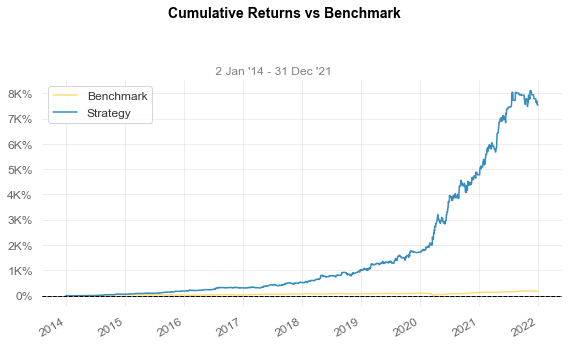

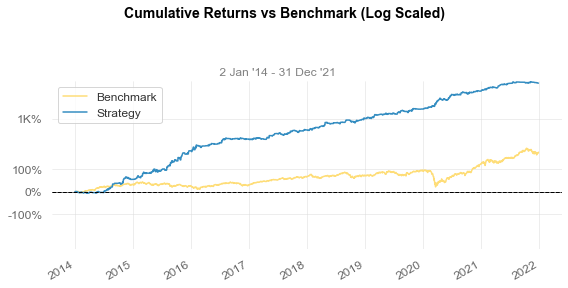

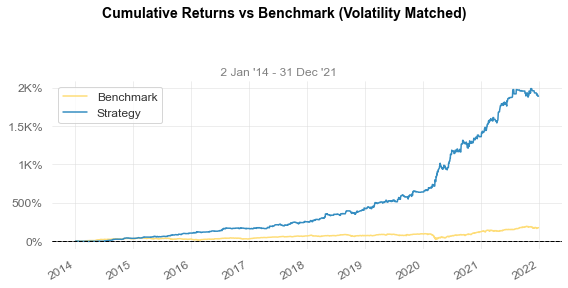

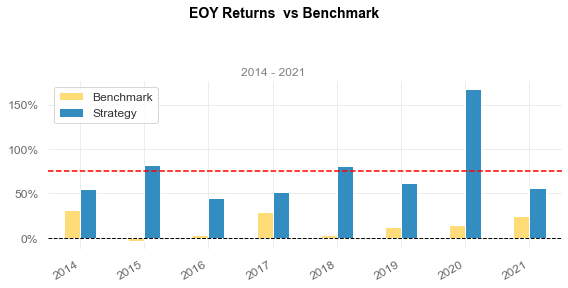

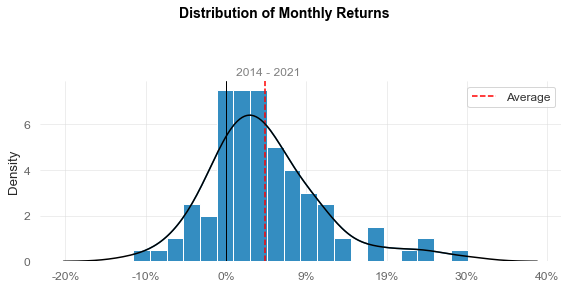

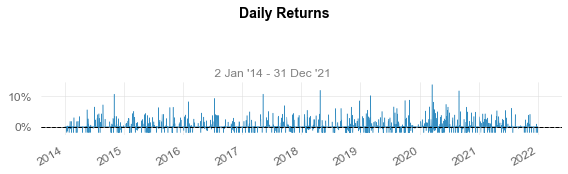

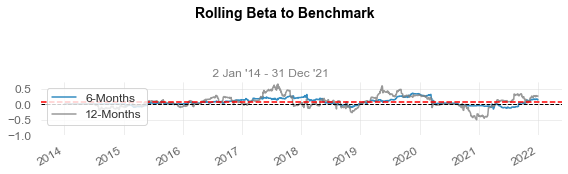

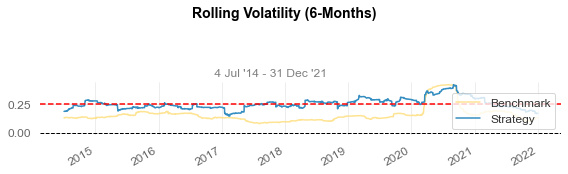

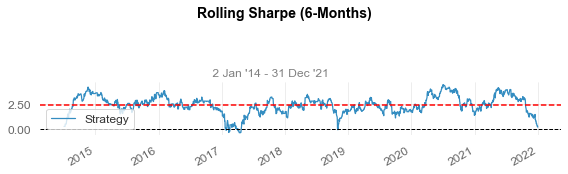

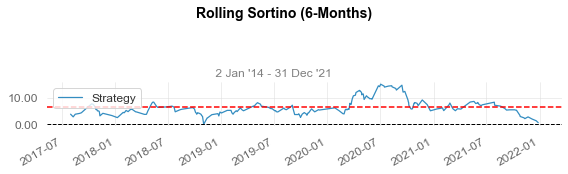

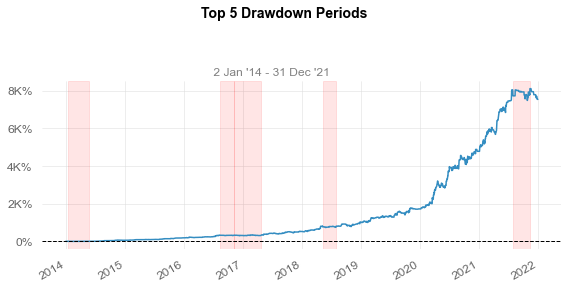

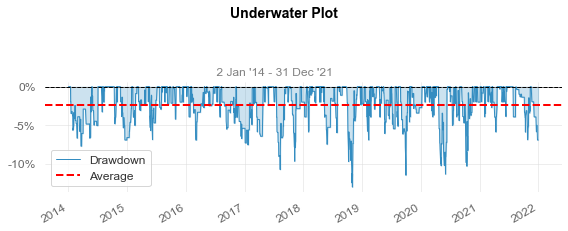

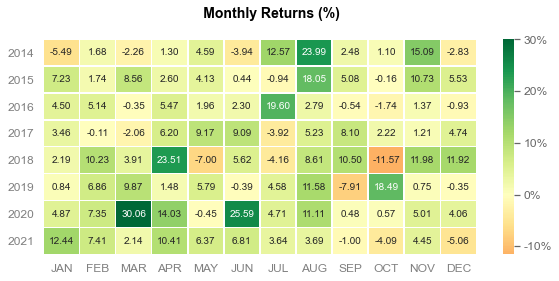

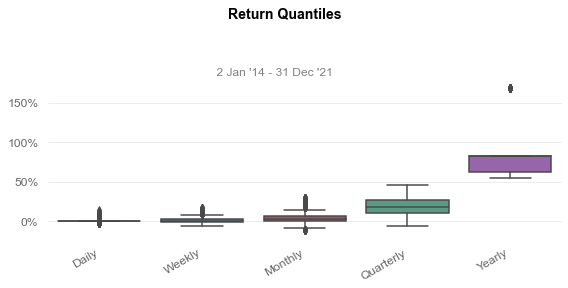

In [34]:
qs.reports.full(returns=equity, benchmark=nifty)

In [35]:
qs.reports.html(returns=equity, benchmark=nifty, output="C:\\Users\\Admin\\Downloads\\26th Feb.html")